In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import EvaluationModule

import xgboost as xgb
import sklearn
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression

(CVXPY) Jul 07 03:39:23 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 07 03:39:23 PM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 07 03:39:23 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

# Data Module

In [23]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="regression_delta", #option: regression, regression_delta, classification, binary_classification
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation='IterativeSVD', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    remove_low_DAS = True,
    save_csv=False, 
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Missing values in train before imputation: 128
Missing values in train after imputation: 0
Missing values in test before imputation: 24
Missing values in test after imputation: 0
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Train.csv
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Test.csv


In [3]:
# read train, test from dataloader
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 531
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   grp                505 non-null    int64  
 1   age                505 non-null    float64
 2   gender             505 non-null    int64  
 3   final_education    505 non-null    int64  
 4   race_grp           505 non-null    int64  
 5   ethnicity          505 non-null    int64  
 6   weight             505 non-null    float64
 7   BMI                505 non-null    float64
 8   height             505 non-null    float64
 9   newsmoker          505 non-null    int64  
 10  smkyrs             505 non-null    float64
 11  numcigs            505 non-null    float64
 12  drinker            505 non-null    int64  
 13  drinksperwk        505 non-null    float64
 14  duration_ra        505 non-null    float64
 15  ara_func_class     505 non-null    int64  
 16  num_tnf            505 non

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   grp                134 non-null    int64  
 1   age                134 non-null    float64
 2   gender             134 non-null    int64  
 3   final_education    134 non-null    int64  
 4   race_grp           134 non-null    int64  
 5   ethnicity          134 non-null    int64  
 6   weight             134 non-null    float64
 7   BMI                134 non-null    float64
 8   height             134 non-null    float64
 9   newsmoker          134 non-null    int64  
 10  smkyrs             134 non-null    float64
 11  numcigs            134 non-null    float64
 12  drinker            134 non-null    int64  
 13  drinksperwk        134 non-null    float64
 14  duration_ra        134 non-null    float64
 15  ara_func_class     134 non-null    int64  
 16  num_tnf            134 non

In [6]:
# get x,y train and test set
X_train = train.iloc[:,:-1] # train.iloc[:,-2]
y_train = train.iloc[:,-1] 
X_test = test.iloc[:,:-1] # test.iloc[:,-2]
y_test = test.iloc[:,-1]

In [7]:
# initialize evaluation module
aml = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge)

In [8]:
X_train

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M
0,1,59.0,0,0,5,2,198.0,33.982910,64.0,0,...,6.0,50.0,55.0,1.375000,40.0,17.13,207.0,826.0,24.0,6.368827
1,0,67.0,0,0,5,1,122.0,21.608970,63.0,3,...,10.0,50.0,40.0,0.250000,35.0,0.43,342.0,752.0,60.0,4.214201
2,2,68.0,0,0,5,1,113.0,20.014865,63.0,3,...,8.0,50.0,20.0,0.142857,15.0,49.55,338.0,714.0,66.0,4.815941
3,2,63.0,0,0,5,1,122.0,20.938965,64.0,0,...,8.0,35.0,70.0,0.000000,65.0,0.19,179.0,1210.0,176.0,3.914583
4,0,70.0,0,2,5,1,117.0,22.847500,60.0,0,...,10.0,65.0,95.0,2.000000,95.0,17.73,523.0,1310.0,279.0,5.601998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,1,76.0,0,0,5,1,105.0,18.597884,63.0,3,...,10.0,75.0,45.0,0.000000,42.0,0.33,146.0,758.0,75.0,4.746973
528,0,83.0,0,0,5,1,131.0,22.483643,64.0,2,...,5.0,45.0,50.0,0.571429,60.0,1.90,26.0,2900.0,270.0,3.461354
529,1,55.0,0,2,2,1,172.0,29.520508,64.0,0,...,8.0,85.0,70.0,1.000000,70.0,5.99,378.0,1270.0,192.0,6.058605
530,1,61.0,0,0,1,1,212.0,36.385742,64.0,3,...,1.0,15.0,30.0,1.000000,80.0,1.77,236.0,1620.0,207.0,3.610704


In [9]:
# aml.cross_validation_split(X_train)

# Model Module

In [10]:
# modelmodule
# Xgb
if "regression" in dataset.challenge:
    model_id = 'xgb'
    save_path = f'../Models/{dataset.challenge}_{model_id}.pkl'
    
    model = xgb.XGBRegressor()
    shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=10, random_state=2022)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring="neg_mean_squared_error", cv=shuffle_split, verbose=0)
    model.fit(X_train, y_train)
    print("cross Validation scores:n {}".format(scores))
    print("Average Cross Validation score :{}".format(scores.mean()))
    # optional, to save and load models using pickle
#     pickle.dump(model, open(save_path, 'wb'))
#     model = pickle.load(open(save_path, 'rb'))
    
    aml.evaluate(model_id, model, test)
elif "classification" in dataset.challenge:
    model = xgb.XGBClassifier(use_label_encoder=False)
    shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=10, random_state=2022)
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring="accuracy", cv=shuffle_split, verbose=0)
    model.fit(X_train, y_train)
    aml.evaluate("xgb", model, test)
    print("cross Validation scores:n {}".format(scores))
    print("Average Cross Validation score :{}".format(scores.mean()))

[15:39:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:30] WARNING: /Users/runner/miniforge3/c

In [11]:
# linear model
if "regression" in dataset.challenge:
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    aml.evaluate("RF", model, test) # input: model and test
elif "classification" in dataset.challenge:
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    aml.evaluate("RF", model, test) # input: model and test

In [12]:
X_test

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M
0,1,51.0,0,0,5,1,133.0,20.220372,68.0,3,...,10.0,70.0,90.0,1.285714,85.0,5.56,469.0,1260.0,114.0,5.366514
1,1,63.0,1,0,5,1,257.0,37.948120,69.0,3,...,2.0,40.0,25.0,0.125000,25.0,3.53,207.0,1110.0,247.0,4.558779
2,1,80.0,0,2,5,2,123.0,23.238108,61.0,3,...,15.0,70.0,90.0,1.000000,85.0,5.67,289.0,1240.0,128.0,4.957527
3,1,54.0,0,0,5,1,141.0,24.199951,64.0,2,...,7.0,65.0,75.0,0.142857,75.0,1.83,305.0,1520.0,202.0,5.144419
4,1,43.0,0,0,5,1,175.0,26.605753,68.0,2,...,11.0,42.0,70.0,0.000000,35.0,0.59,304.0,781.0,160.0,5.130927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0,55.0,0,2,5,1,161.0,28.516755,63.0,0,...,3.0,35.0,75.0,0.125000,75.0,14.35,524.0,1300.0,128.0,5.158176
130,0,62.0,1,0,1,1,188.0,27.759714,69.0,3,...,14.0,90.0,33.0,0.250000,30.0,1.83,507.0,1730.0,107.0,5.348560
131,1,66.0,0,2,1,1,146.0,28.510556,60.0,2,...,4.0,45.0,55.0,1.428571,55.0,3.87,174.0,1060.0,185.0,4.443833
132,0,89.0,0,0,5,1,134.0,22.296331,65.0,3,...,4.0,50.0,17.0,0.125000,87.0,9.96,112.0,538.0,81.0,3.991645


# Evaluation on test set

In [13]:
regression, classification = aml.leaderboard()

In [14]:
regression

In [15]:
classification

,model,Accuracy,F1-Score
0,xgb,0.425373,0.416925
1,RF,0.455224,0.447214


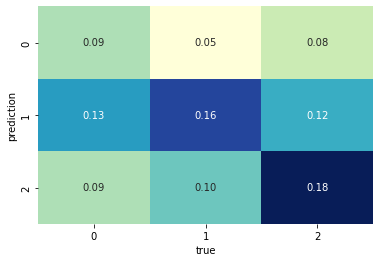

In [16]:
# rows: true, columns: pred
aml.confusion_matrix("xgb",plot=True, normalize=True)

In [17]:
# true
aml.saved_model['xgb'][0].value_counts()

2    51
1    42
0    41
Name: true, dtype: int64

In [18]:
# pred
aml.saved_model['xgb'][1].value_counts()

1    54
2    50
0    30
Name: pred, dtype: int64

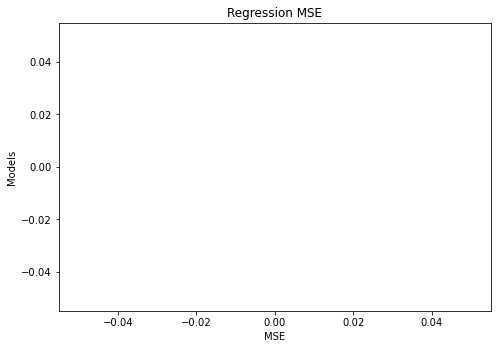

In [19]:
aml.plot_results('regression','MSE')

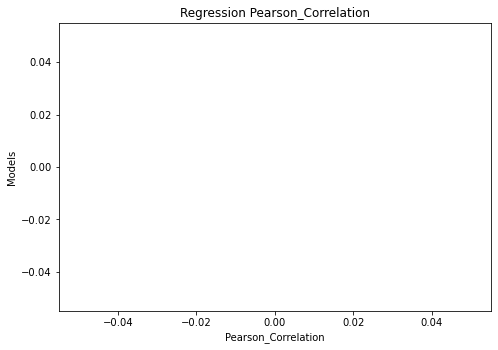

In [20]:
aml.plot_results('regression','Pearson_Correlation')

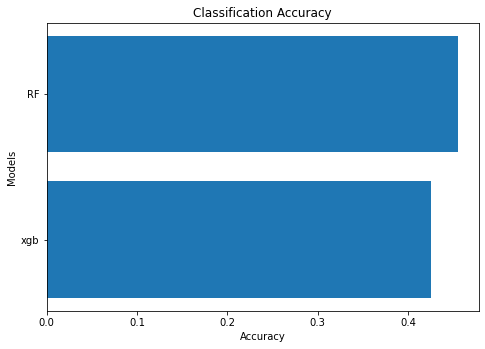

In [21]:
aml.plot_results('classification','Accuracy')

In [22]:
# aml.save_outputs(dataset,"../leaderboard")